In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(1)

## Loading the datasets, i.e loading frames for few actions

In [2]:
#loading and prepping data
#initially only one action
dframe = pd.read_csv('./csv_data/action_1.csv')
dframe2 = pd.read_csv('./csv_data/action_2.csv')
dframe3 = pd.read_csv('./csv_data/action_3.csv')
dframe4 = pd.read_csv('./csv_data/action_4.csv')
dframe5 = pd.read_csv('./csv_data/action_5.csv')
dframe6 = pd.read_csv('./csv_data/action_6.csv')
dframe7 = pd.read_csv('./csv_data/action_7.csv')

dframe8 = pd.read_csv('./csv_data/action_8.csv')
dframe9 = pd.read_csv('./csv_data/action_9.csv')
dframe10 = pd.read_csv('./csv_data/action_10.csv')
dframe11 = pd.read_csv('./csv_data/action_11.csv')
dframe12 = pd.read_csv('./csv_data/action_12.csv')
dframe13 = pd.read_csv('./csv_data/action_13.csv')
dframe14 = pd.read_csv('./csv_data/action_14.csv')

dframe15 = pd.read_csv('./csv_data/action_15.csv')
dframe16 = pd.read_csv('./csv_data/action_16.csv')
dframe17 = pd.read_csv('./csv_data/action_17.csv')
dframe18 = pd.read_csv('./csv_data/action_18.csv')
dframe19 = pd.read_csv('./csv_data/action_19.csv')
dframe20 = pd.read_csv('./csv_data/action_20.csv')
dframe21 = pd.read_csv('./csv_data/action_21.csv')

#to look at data
dframe.iloc[0:5, :]

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,label,id,video_id
0,-0.382997,-0.419442,3.449989,-0.366909,-0.092619,3.443680,-0.353380,0.229542,3.427116,-0.391862,...,3.636719,-0.435790,-0.536338,3.280097,-0.364369,-0.491436,3.269750,1,72057594037944340,0
1,-0.383146,-0.419292,3.450006,-0.367569,-0.092003,3.443895,-0.353885,0.230300,3.427162,-0.391820,...,3.633053,-0.436031,-0.536649,3.281972,-0.358806,-0.471054,3.269975,1,72057594037944340,0
2,-0.385776,-0.421191,3.449611,-0.369506,-0.092775,3.443796,-0.354571,0.230189,3.426965,-0.403822,...,3.632370,-0.436489,-0.536484,3.286322,-0.358079,-0.470344,3.270202,1,72057594037944340,0
3,-0.385807,-0.421205,3.449582,-0.369576,-0.092714,3.443878,-0.354524,0.230369,3.427140,-0.403580,...,3.499778,-0.441701,-0.533234,3.278971,-0.360298,-0.476572,3.268953,1,72057594037944340,0
4,-0.357840,-0.420304,3.438846,-0.364956,-0.092426,3.442334,-0.354907,0.230391,3.427352,-0.405945,...,3.400878,-0.430001,-0.536492,3.278641,-0.358697,-0.471415,3.270685,1,72057594037944340,0


## Some utility functions to split the datasets and loading the datasets in batch

In [3]:
#making test and train split
#the recentering has been done so that the pelvic joint is always at the origin
#labels are to be zero indexed
def train_test_split(dframe_list):
    train_split = np.empty(0, dtype=object)
    test_split = np.empty(0, dtype=object)
    for dframe in dframe_list:
        label = dframe.iloc[0,75]-1
        num_samples = len(dframe.iloc[:,:])
        video_ids = np.unique(dframe.iloc[:,-1].values)
        train_video_ids = video_ids[:-35]
        test_video_ids = video_ids[-35:]
        train_split1 = np.empty(len(train_video_ids), dtype=object)
        test_split1 = np.empty(len(test_video_ids), dtype=object)
        for idx,i in enumerate(train_video_ids):
            train_split1[idx] = dframe.loc[dframe['video_id'] == i].values[:,0:75]
            for fidx, f in enumerate(train_split1[idx]):
                f = np.reshape(f, (25,3))
                f = f-f[0,:]
                f = np.reshape(f, (1,75))
                train_split1[idx][fidx] = f
            train_split1[idx] = (train_split1[idx], label)

        for idx,i in enumerate(test_video_ids):
            test_split1[idx] = dframe.loc[dframe['video_id'] == i].values[:,0:75]
            for fidx, f in enumerate(test_split1[idx]):
                f = np.reshape(f, (25,3))
                f = f-f[0,:]
                f = np.reshape(f, (1,75))
                test_split1[idx][fidx] = f
            test_split1[idx] = (test_split1[idx], label)
        train_split = np.concatenate((train_split, train_split1))
        test_split = np.concatenate((test_split, test_split1))
    return train_split, test_split

train_split, test_split = train_test_split([dframe, dframe2, dframe3, dframe4, dframe5, dframe6, dframe7, dframe8, dframe9,
                                           dframe10, dframe11, dframe12, dframe13, dframe14, dframe15, dframe16, dframe17,
                                           dframe19, dframe20, dframe21])

# #looking at split
train_split[0:3]

array([ (array([[ 0.       ,  0.       ,  0.       , ...,  0.0186279, -0.0719937,
        -0.180239 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.0243399, -0.0517625,
        -0.180031 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.0276977, -0.0491529,
        -0.179409 ],
       ..., 
       [ 0.       ,  0.       ,  0.       , ..., -0.0563203, -0.0113986,
        -0.174284 ],
       [ 0.       ,  0.       ,  0.       , ..., -0.0561737, -0.0162162,
        -0.171437 ],
       [ 0.       ,  0.       ,  0.       , ..., -0.0559275, -0.0062211,
        -0.172233 ]]), 0),
       (array([[ 0.        ,  0.        ,  0.        , ...,  0.01849598,
         0.0721854 , -0.16189   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.10443107,
         0.05172237, -0.133567  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.08676113,
         0.05116256, -0.145192  ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.10355284,
         0.52594266, -

In [4]:
SEQ_LEN = None
def Data_gen( train_split, SEQ_LEN):
    X = list(train_split)
    while(True):
        databatch = random.sample(X, 1)[0]
        databatch, label = databatch[0], databatch[1]
        if SEQ_LEN is not None:
            if len(databatch) > SEQ_LEN:
                databatch = databatch[0:SEQ_LEN]
            elif len(databatch) < SEQ_LEN:
                databatch = np.concatenate((databatch, np.zeros((SEQ_LEN - len(databatch), 75))))
            else:
                pass
            yield databatch,label
        else:
            yield databatch,label
ACTd = Data_gen(train_split, SEQ_LEN)
#to look at batch created by Actd
next(ACTd)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.1984679 ,
         -0.07641443, -0.174599  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.2255742 ,
         -0.06490111, -0.171769  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.200963  ,
         -0.04734985, -0.174335  ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.1224071 ,
         -0.0497683 , -0.055919  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.1209471 ,
         -0.02962219, -0.043966  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.120231  ,
         -0.03948976, -0.037324  ]]), 1)

In [5]:
def Val_data_gen(test_split):
    X = list(test_split)
    N = len(X)
    ctr = 0
    while True:
        databatch, label = X[ctr]
        ctr += 1
        if ctr==N:
            ctr=0
        yield databatch, label
ACTtest = Val_data_gen(test_split)
next(ACTtest)

(array([[ 0.        ,  0.        ,  0.        , ..., -0.0767775 ,
          0.20664589, -0.25646   ],
        [ 0.        ,  0.        ,  0.        , ..., -0.0775596 ,
          0.20458439, -0.256738  ],
        [ 0.        ,  0.        ,  0.        , ..., -0.1224914 ,
          0.23614434, -0.302416  ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ..., -0.0581151 ,
          0.6969325 , -0.243524  ],
        [ 0.        ,  0.        ,  0.        , ..., -0.0198701 ,
          0.5908162 , -0.171189  ],
        [ 0.        ,  0.        ,  0.        , ..., -0.0330709 ,
          0.5785297 , -0.147728  ]]), 0)

In [30]:
def evaluate_val_accuracy(model):
    model = model.cpu()
    model.eval()
    N = len(list(test_split))
    correct_count = 0
    for i in range(N):
        X,Y = next(ACTtest)
        X_l = autograd.Variable(torch.from_numpy(X).float()).cpu()
        X_l = X_l.view(len(X), 1, -1)
        x3_d = X_l.data.numpy()
        x2_d = np.reshape(x3_d, (-1,25,3))
        x2_1_d = np.reshape(x2_d[:,:,1:3], (-1,1,50))
        x2_2_d = np.reshape(x2_d[:,:,0:2], (-1,1,50))
        x2_3_d = np.reshape(x2_d[:,:,[0,2]], (-1,1,50))
        x2_1 = autograd.Variable(torch.from_numpy(x2_1_d))
        x2_2 = autograd.Variable(torch.from_numpy(x2_2_d))
        x2_3 = autograd.Variable(torch.from_numpy(x2_3_d))
#         print(X_l, x2_1, x2_2, x2_3)
        y_hat, cord3, cord2_1, cord2_2, cord2_3 = model(X_l, x2_1, x2_2, x2_3, 'test')
        pred_label = y_hat.data.max(1)[1].numpy()[0]
        if pred_label == Y:
            correct_count += 1
    return correct_count*100/N

## LSTM Classifier model defination and intialisation

In [51]:
#action LSTM
class LSTMClassifierX4(nn.Module):
    def __init__(self, joints_dim, hidden_dim, label_size, batch_size, num_layers, kernel_size):
        super(LSTMClassifierX4, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        joints_dim2d = joints_dim - 25
        
        self.lstm3 = nn.LSTM(joints_dim, hidden_dim, num_layers=self.num_layers)
        self.conv1_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
        self.lstm2_1 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_1 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_2 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_2 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_3 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
        self.dense3 = nn.Linear(hidden_dim, joints_dim)
        self.dense2_1 = nn.Linear(hidden_dim, joints_dim2d)
        self.dense2_2 = nn.Linear(hidden_dim, joints_dim2d)
        self.dense2_3 = nn.Linear(hidden_dim, joints_dim2d)
        
        self.hidden3 = self.init_hidden3()
        self.hidden2_1 = self.init_hidden2_1()
        self.hidden2_2 = self.init_hidden2_2()
        self.hidden2_3 = self.init_hidden2_3()
        
        self.hidden2label = nn.Linear(hidden_dim, label_size)
    
    def init_hidden3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)))
    def init_hidden2_1(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)))
    def init_hidden2_2(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)))
    def init_hidden2_3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)))
    
    def forward(self, joints3d_vec, joints2d_vec1, joints2d_vec2, joints2d_vec3, mode):
#         print('Im in')
        x3, x2_1, x2_2, x2_3 = joints3d_vec, joints2d_vec1, joints2d_vec2, joints2d_vec3
        if mode == 'train':
            self.hidden3 = (self.hidden3[0].cuda(), self.hidden3[1].cuda())
            self.hidden2_1 = (self.hidden2_1[0].cuda(), self.hidden2_1[1].cuda())
            self.hidden2_2 = (self.hidden2_2[0].cuda(), self.hidden2_2[1].cuda())
            self.hidden2_3 = (self.hidden2_3[0].cuda(), self.hidden2_3[1].cuda())
        elif mode == 'test':
            self.hidden3 = (self.hidden3[0].cpu(), self.hidden3[1].cpu())
            self.hidden2_1 = (self.hidden2_1[0].cpu(), self.hidden2_1[1].cpu())
            self.hidden2_2 = (self.hidden2_2[0].cpu(), self.hidden2_2[1].cpu())
            self.hidden2_3 = (self.hidden2_3[0].cpu(), self.hidden2_3[1].cpu())
        
        lstm_out3, self.hidden3 = self.lstm3(x3, self.hidden3)
        lstm_out2_1, self.hidden2_1 = self.lstm2_1(x2_1, self.hidden2_1)
        lstm_out2_2, self.hidden2_2 = self.lstm2_2(x2_2, self.hidden2_2)
        lstm_out2_3, self.hidden2_3 = self.lstm2_3(x2_3, self.hidden2_3)
    
        t3 = lstm_out3[-1].view(self.batch_size,1,-1)
        t2_1 = lstm_out2_1[-1].view(self.batch_size,1,-1)
        t2_2 = lstm_out2_2[-1].view(self.batch_size,1,-1)
        t2_3 = lstm_out2_3[-1].view(self.batch_size,1,-1)

        y3 = self.conv1_3(t3)
        y2_1 = self.conv1_2_1(t2_1)
        y2_2 = self.conv1_2_2(t2_2)
        y2_3 = self.conv1_2_3(t2_3)
        
        yf = y3+y2_1+y2_2+y2_3    
        yf = yf.view(-1, self.hidden_dim)
        y  = self.hidden2label(yf)
        
        ## for outputs of other timesteps
        t_prime3 = lstm_out3[:]
        t_prime2_1 = lstm_out2_1[:]
        t_prime2_2 = lstm_out2_2[:]
        t_prime2_3 = lstm_out2_3[:]
        
        if mode == 'train':
            y3_others = autograd.Variable(torch.zeros((t_prime3.size()[0], t_prime3.size()[1], 75)).cuda())
            y2_1_others = autograd.Variable(torch.zeros((t_prime2_1.size()[0], t_prime2_1.size()[1], 50)).cuda())
            y2_2_others = autograd.Variable(torch.zeros((t_prime2_2.size()[0], t_prime2_2.size()[1], 50)).cuda())
            y2_3_others = autograd.Variable(torch.zeros((t_prime2_3.size()[0], t_prime2_3.size()[1], 50)).cuda())
        elif mode == 'test':
            y3_others = autograd.Variable(torch.zeros((t_prime3.size()[0], t_prime3.size()[1], 75)))
            y2_1_others = autograd.Variable(torch.zeros((t_prime2_1.size()[0], t_prime2_1.size()[1], 50)))
            y2_2_others = autograd.Variable(torch.zeros((t_prime2_2.size()[0], t_prime2_2.size()[1], 50)))
            y2_3_others = autograd.Variable(torch.zeros((t_prime2_3.size()[0], t_prime2_3.size()[1], 50)))
        
        for idx,tp in enumerate(t_prime3):
            y3_others[idx, :, :] = self.dense3(tp)
        for idx,tp in enumerate(t_prime2_1):
            y2_1_others[idx, :, :] = self.dense2_1(tp)
        for idx,tp in enumerate(t_prime2_2):
            y2_2_others[idx, :, :] = self.dense2_2(tp)
        for idx,tp in enumerate(t_prime3):
            y2_3_others[idx, :, :] = self.dense2_3(tp)
        log_probs = F.log_softmax(y, dim=1)
        return log_probs, y3_others, y2_1_others, y2_2_others, y2_3_others #others as in the output from the cells behind the last cell
#instanstiating a model
model0 = LSTMClassifierX4(75, 512, 21, 1, 2, 3)
#to do stuff in CUDA
model0 = model0.cuda()

In [52]:
evaluate_val_accuracy(model0)

5.0

## Training the model

Starting the training ...
epoch 0 starting ...
epoch: 0 iterations: 0 loss :2.7227
epoch: 0 iterations: 20 loss :3.21121
epoch: 0 iterations: 40 loss :3.09657
epoch: 0 iterations: 60 loss :2.70353
epoch: 0 iterations: 80 loss :3.2691
epoch 1 starting ...
epoch: 1 iterations: 0 loss :2.64049
epoch: 1 iterations: 20 loss :2.97116
epoch: 1 iterations: 40 loss :2.63122
epoch: 1 iterations: 60 loss :2.94041
epoch: 1 iterations: 80 loss :3.22022
epoch 2 starting ...
epoch: 2 iterations: 0 loss :2.9557
epoch: 2 iterations: 20 loss :3.29058
epoch: 2 iterations: 40 loss :3.36734
epoch: 2 iterations: 60 loss :2.73612
epoch: 2 iterations: 80 loss :3.55771
epoch 3 starting ...
epoch: 3 iterations: 0 loss :3.01407
epoch: 3 iterations: 20 loss :3.10344
epoch: 3 iterations: 40 loss :2.88669
epoch: 3 iterations: 60 loss :3.19071
epoch: 3 iterations: 80 loss :3.16911
epoch 4 starting ...
epoch: 4 iterations: 0 loss :2.93585
epoch: 4 iterations: 20 loss :3.022
epoch: 4 iterations: 40 loss :2.93014
epoch

Text(0,0.5,'avg loss')

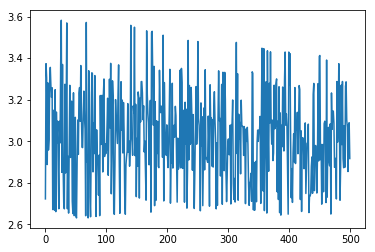

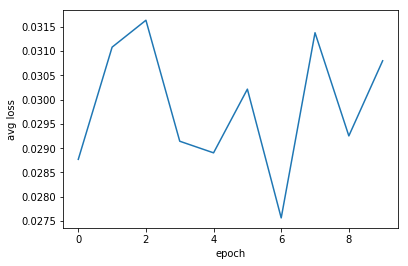

In [53]:
#training function
def train(model, num_epoch, num_iter, rec_interval, disp_interval):
    optimizer = optim.Adam(model.parameters(), lr = 8e-6)
    loss_values = []
    avg_loss_values = []
    rec_step = 0
    print('Starting the training ...')
    torch.cuda.synchronize()
    for eph in range(num_epoch):
        print('epoch {} starting ...'.format(eph))
        avg_loss = 0
        n_samples = 0
        torch.cuda.synchronize()
        model = model.cuda()
        for i in range(num_iter):
            model.hidden3 = (model.hidden3[0].detach(), model.hidden3[1].detach())
            model.hidden2_1 = (model.hidden2_1[0].detach(), model.hidden2_1[1].detach())
            model.hidden2_2 = (model.hidden2_2[0].detach(), model.hidden2_2[1].detach())
            model.hidden2_3 = (model.hidden2_3[0].detach(), model.hidden2_3[1].detach())
            model.zero_grad()
            X,Y = next(ACTd)
            n_samples += len(X)
            X = autograd.Variable(torch.from_numpy(X).float().cuda())
            X = X.view(len(X), 1, -1)
            Y = autograd.Variable(torch.LongTensor(np.array([Y])).cuda())
            
            X2 = X.view(-1, 25, 3)
            X2_1 = X2[:,:,1:3].contiguous().view(-1, 1, 50)
            X2_2 = X2[:,:,0:2].contiguous().view(-1, 1, 50)
            X2_3 = X2[:,:,[0,2]].contiguous().view(-1, 1, 50)
            
            y_hat, cord3, cord2_1, cord2_2, cord2_3 = model(X, X2_1, X2_2, X2_3, 'train')
            
            loss_classification = F.cross_entropy(y_hat, Y)
#             loss_regr3d = F.mse_loss(cord3, X)
#             loss_regr2d_1 = F.mse_loss(cord2_1, X2_1)
#             loss_regr2d_2 = F.mse_loss(cord2_2, X2_2)
#             loss_regr2d_3 = F.mse_loss(cord2_3, X2_3)
            
#             loss = loss_classification + loss_regr3d + loss_regr2d_1 + loss_regr2d_2 + loss_regr2d_3
            loss = loss_classification
            avg_loss += loss.data[0]
            
            if i % disp_interval == 0:
                print('epoch: %d iterations: %d loss :%g' % (eph, i, loss.data[0]))
            if rec_step%rec_interval==0:
                loss_values.append(loss.data[0])
            
            loss.backward()     
            optimizer.step()
            rec_step += 1
            
        avg_loss /= n_samples
        avg_loss_values.append(avg_loss)
        #evaluating model accuracy
#         acc = evaluate_accuracy(model, ACTtest)
#         print('epoch: {} <====train track===> avg_loss: {}, accuracy: {}% \n'.format(eph, avg_loss, acc))
    return loss_values, avg_loss_values


loss_vals, avg_loss_vals = train(model0, 10, 100, 2, 20)
plt.figure()
plt.plot(loss_vals)
plt.figure()
plt.plot(avg_loss_vals)
plt.xlabel('epoch')
plt.ylabel('avg loss')

## observations
* better to use the log_softmax instead of softmax
* decrease lr succicesively to get better results

In [ ]:
#training function
def train(model, num_epoch, num_iter, rec_interval, disp_interval):
    optimizer = optim.Adam(model.parameters(), lr = 8e-6)
    loss_values = []
    avg_loss_values = []
    rec_step = 0
    print('Starting the training ...')
    torch.cuda.synchronize()
    for eph in range(num_epoch):
        print('epoch {} starting ...'.format(eph))
        avg_loss = 0
        n_samples = 0
        torch.cuda.synchronize()
        for i in range(num_iter):
            model.hidden3 = (model.hidden3[0].detach(), model.hidden3[1].detach())
            model.hidden2_1 = (model.hidden2_1[0].detach(), model.hidden2_1[1].detach())
            model.hidden2_2 = (model.hidden2_2[0].detach(), model.hidden2_2[1].detach())
            model.hidden2_3 = (model.hidden2_3[0].detach(), model.hidden2_3[1].detach())
            model.zero_grad()
            X,Y = next(ACTd)
            n_samples += len(X)
            X = autograd.Variable(torch.from_numpy(X).float().cuda())
            X = X.view(len(X), 1, -1)
            Y = autograd.Variable(torch.LongTensor(np.array([Y])).cuda())
            
            X2 = X.view(-1, 25, 3)
            X2_1 = X2[:,:,1:3].contiguous().view(-1, 1, 50)
            X2_2 = X2[:,:,0:2].contiguous().view(-1, 1, 50)
            X2_3 = X2[:,:,[0,2]].contiguous().view(-1, 1, 50)
            
            y_hat, cord3, cord2_1, cord2_2, cord2_3 = model(X)
#             print('cord3 : {}'.format(cord3.size()))
#             print('X : {}'.format(X.size()))
#             print('cord3 : {}'.format(cord3.size()))
            
            loss_classification = F.cross_entropy(y_hat, Y)
            loss_regr3d = F.mse_loss(cord3, X)
#             print('loss_regr3d : {}'.format(loss_regr3d))
            
            loss_regr2d_1 = F.mse_loss(cord2_1, X2_1)
            loss_regr2d_2 = F.mse_loss(cord2_2, X2_2)
            loss_regr2d_3 = F.mse_loss(cord2_3, X2_3)
            
            loss = loss_classification + loss_regr3d + loss_regr2d_1 + loss_regr2d_2 + loss_regr2d_3
#             print(loss)
            avg_loss += loss.data[0]
            
            if i % disp_interval == 0:
                print('epoch: %d iterations: %d loss :%g' % (eph, i, loss.data[0]))
            if rec_step%rec_interval==0:
                loss_values.append(loss.data[0])
            
            loss.backward()     
            optimizer.step()
            rec_step += 1
            
        avg_loss /= n_samples
        avg_loss_values.append(avg_loss)
        #evaluating model accuracy
        acc = evaluate_accuracy(model, ACTtest)
        print('epoch: {} <====train track===> avg_loss: {}, accuracy: {}% \n'.format(eph, avg_loss, acc))
    return loss_values, avg_loss_values


loss_vals, avg_loss_vals = train(model0, 100, 1000, 2, 100)
plt.figure()
plt.plot(loss_vals)
plt.figure()
plt.plot(avg_loss_vals)
plt.xlabel('epoch')
plt.ylabel('avg loss')

In [ ]:
a = autograd.Variable(torch.rand(3,5).cuda())
a

In [ ]:
# saving the model
def save_model(model_name, path, model):
    p = path+'/'+model_name
    print('saving at {}'.format(p))
    torch.save(model.state_dict(), p)
    print('saved at {}'.format(p))

In [ ]:
save_model('LSTMClassifierX1_c7.pth', './checkpoints', model0)

In [ ]:
mtest = LSTMClassifier(75, 512, 7, 1, 2, 3).cuda()
mtest.load_state_dict(torch.load('./checkpoints/LSTMClassifierX1_c7.pth'))

In [ ]:
mtest.lstm.weight_ih_l0